In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_NAME = "bert-base-multilingual-cased"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 31
EPOCHS = 3
MAX_LEN = 128

df = pd.read_csv("augmented_dataset.csv")

label_encoder = LabelEncoder()
df["label_enc"] = label_encoder.fit_transform(df["label"])
NUM_LABELS = len(label_encoder.classes_)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["label_enc"].tolist(), test_size=0.2, random_state=42
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")

class IndoDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx]
        }

train_dataset = IndoDataset(train_encodings, train_labels)
val_dataset = IndoDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=5e-5)



for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")

    model.eval()
    preds, trues, probs = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            prob = torch.softmax(logits, dim=1)[:, 1]

            preds.extend(predictions.cpu().numpy())
            trues.extend(labels.cpu().numpy())
            probs.extend(prob.cpu().numpy())


    acc = accuracy_score(trues, preds)
    print(f"Validation Accuracy: {acc:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 1735/1735 [19:30<00:00,  1.48it/s]


Epoch 1 Loss: 811.9629
Validation Accuracy: 0.8173


Epoch 2: 100%|██████████| 1735/1735 [19:34<00:00,  1.48it/s]


Epoch 2 Loss: 411.2861
Validation Accuracy: 0.9255


Epoch 3: 100%|██████████| 1735/1735 [19:34<00:00,  1.48it/s]


Epoch 3 Loss: 197.5496
Validation Accuracy: 0.9476



Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.95      0.95      6703
    positive       0.95      0.94      0.95      6743

    accuracy                           0.95     13446
   macro avg       0.95      0.95      0.95     13446
weighted avg       0.95      0.95      0.95     13446



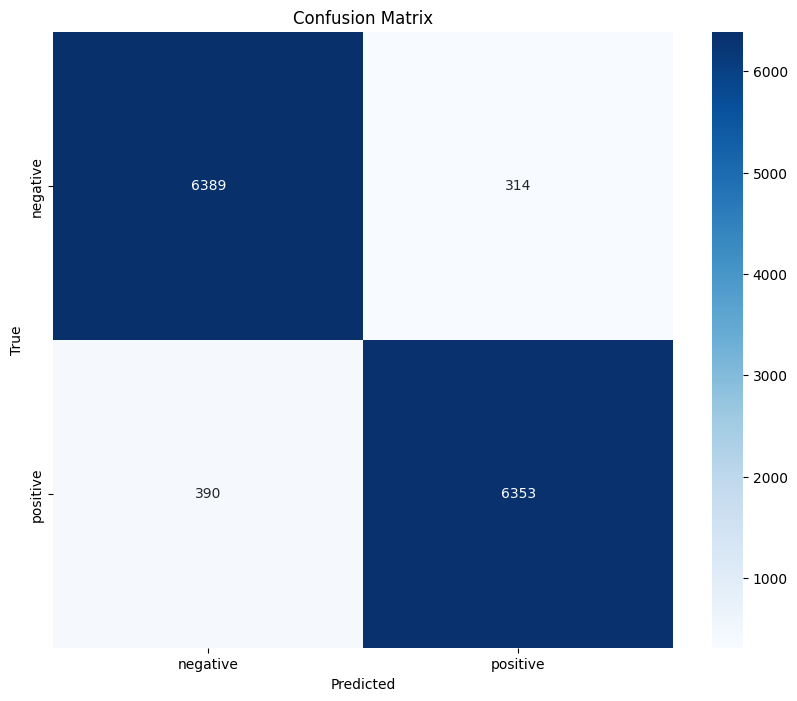

In [2]:
import numpy as np

used_labels = sorted(np.unique(trues + preds))
target_names = [label_encoder.classes_[i] for i in used_labels]

print("\nClassification Report:")
print(classification_report(trues, preds, labels=used_labels, target_names=target_names))

cm = confusion_matrix(trues, preds, labels=used_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [9]:
# Save locally
model.save_pretrained("./my_saved_model")
tokenizer.save_pretrained("./my_saved_model")

('./my_saved_model/tokenizer_config.json',
 './my_saved_model/special_tokens_map.json',
 './my_saved_model/vocab.txt',
 './my_saved_model/added_tokens.json',
 './my_saved_model/tokenizer.json')

In [4]:
import pickle

with open("label_encoder_indobert.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle

def load_model_components(model_path="my_saved_model", encoder_path="label_encoder_indobert.pkl", device="cuda" if torch.cuda.is_available() else "cpu"):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

    with open(encoder_path, "rb") as f:
        label_encoder = pickle.load(f)

    return model, tokenizer, label_encoder, device

def predict_sentence(text, model, tokenizer, label_encoder, device, max_len=128):
    model.eval()

    # Tokenisasi
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()

    label = label_encoder.inverse_transform([predicted_class])[0]
    return label

ROC AUC Score: 0.9848


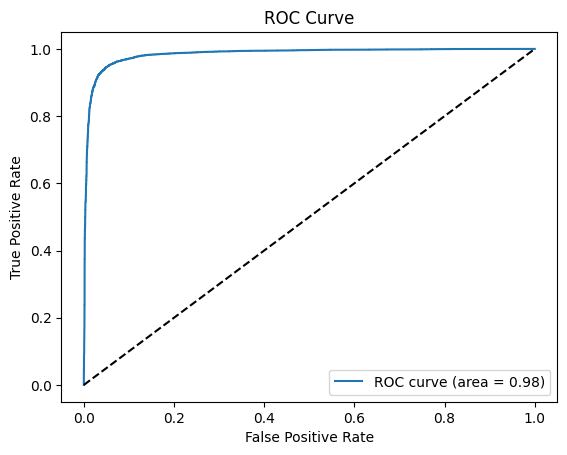

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate ROC AUC
auc = roc_auc_score(trues, probs)
print(f"ROC AUC Score: {auc:.4f}")

# Calculate ROC curve
fpr, tpr, _ = roc_curve(trues, probs)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [7]:
model, tokenizer, label_encoder, device = load_model_components()

kalimat = "Film ini bagus sekali dan saya suka dengan film ini!"
hasil = predict_sentence(kalimat, model, tokenizer, label_encoder, device)

print("Hasil Prediksi:", hasil)

Hasil Prediksi: positive


In [8]:
model, tokenizer, label_encoder, device = load_model_components()

kalimat = "Film ini jelek sekali dan saya benci dengan film ini!"
hasil = predict_sentence(kalimat, model, tokenizer, label_encoder, device)

print("Hasil Prediksi:", hasil)

Hasil Prediksi: negative
